In [1]:
"""
There are two variants to try: in one h and m encoding is first converted to noise...


"""
%run common/imp_and_args1.ipynb
if ntbk:
    sys.argv = ['main',
                '--niter', '10000', ]#, ]#, "--critic_iters", "5"] , '--useLN'
print(sys.argv)
#Now add some parser argument here, commented examples follow
#Boolean, action is what it will be set to when passed
#parser.add_argument('--notLog', action='store_true', help='if passed, no logging will happen. Logging is off for jupyter anyways.;')
#String
#parser.add_argument('--opFolder', default='', help='Override the logging folder.')
#int
#parser.add_argument('--seed', type=int, default=1, help='Seed for pyTorcj.')
#and float
#parser.add_argument('--clamp_lower', type=float, default=-0.01)





parser.add_argument('--newGetZ', action='store_true', 
                    help="if passed, GetZ won't be created form D, "+
                    " but will be created from scratch. And Batch "+
                    " Normalization would be used.")

parser.add_argument('--useLN', action='store_true', 
                    help="if passed, Layer Norm would be used, else batch norm.")
parser.add_argument('--getZ', action='store_true', 
                    help="if passed, then inverse mapping will get z, else it will get L.")

%run common/args_and_rest.ipynb
g_nz = opt.hm_gen_size + opt.nz
fixed_noise = torch.randn(opt.batchSize, g_nz)#, 1, 1)
if cuda:
    fixed_noise = fixed_noise.cuda(gpu)
%run common/Utils.ipynb
%config Completer.use_jedi = False

['main', '--niter', '10000']
Namespace(adam=False, batchSize=64, beta1=0.5, beta2=0.9, clamp_lower=-0.01, clamp_upper=0.01, critic_iters=5, dataroot='/home/aknirala/data/lsun', dataset='diverse_clocks', dim=64, fineSize=64, getZ=False, hm_gen_size=30, lambda_value=10.0, loadSize=96, lrD=0.0002, lrG=0.0002, nEpochs=5, nc=3, ndf=64, newGetZ=False, ngf=64, ngpu=1, niter=10000, noCuda=False, noise='normal', notLog=False, nz=100, opFolder='', resumeFldr='', seed=1, useLN=False, workers=8)
OP folder won't be created as we are in jupyter notebook and logging is off
Arguments are:  Namespace(adam=False, batchSize=64, beta1=0.5, beta2=0.9, clamp_lower=-0.01, clamp_upper=0.01, critic_iters=5, dataroot='/home/aknirala/data/lsun', dataset='diverse_clocks', dim=64, fineSize=64, getZ=False, hm_gen_size=30, lambda_value=10.0, loadSize=96, lrD=0.0002, lrG=0.0002, nEpochs=5, nc=3, ndf=64, newGetZ=False, ngf=64, ngpu=1, niter=10000, noCuda=False, noise='normal', notLog=False, nz=100, opFolder='', resume

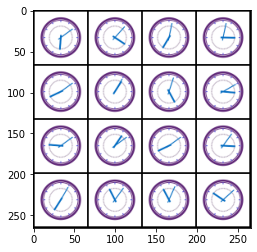

In [2]:
dset2 = same_style_clocks(randSeed=1, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(64),
        transforms.CenterCrop(64),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]))
dload2 = torch.utils.data.DataLoader(dset2, batch_size=opt.batchSize,
                                            shuffle=True, num_workers=int(opt.workers))
same_style_iter = iter(dload2)
data = same_style_iter.next()
clocks = data[0]#.reshape(-1, 3, 64, 64)
plt.imshow(vutils.make_grid(
     clocks[:16],
    padding = 2, nrow = 4, normalize = True
).numpy().transpose([1, 2, 0]))


In [3]:
%run freezed/WGAN_PG.ipynb

In [4]:
class PreGen(nn.Module):
    def __init__(self):
        super(PreGen, self).__init__()
        global opt
        self.main = nn.Sequential()
        L1 = nn.Linear(72, 1024)
        relu1 = nn.ReLU()
        L2 = nn.Linear(1024, 1024)
        relu2 = nn.ReLU()
        L3 = nn.Linear(1024, opt.hm_gen_size)
        self.main.add_module("PreGen_L1", L1)
        self.main.add_module("PreGen_relu1", relu1)
        self.main.add_module("PreGen_L2", L2)
        self.main.add_module("PreGen_relu2", relu2)
        self.main.add_module("PreGen_L3", L3)
    def forward(self, x):
        return self.main(x)

In [5]:
preG = PreGen()
optPreG = optim.Adam(preG.parameters(), lr=opt.lrD, betas=(opt.beta1, opt.beta2))
s_noise = torch.randn(opt.nz)
s_style_noise = s_noise.expand((opt.batchSize, opt.nz))
mse = nn.MSELoss()
if cuda:
    preG = preG.cuda(gpu)
    s_style_noise = s_style_noise.cuda(gpu)
    mse = mse.cuda(gpu)

In [6]:
org_r_state = np.random.get_state()
np.random.seed(2)
#This is being done coz of multi-threading (minimize the effect of drastic change)
same_style_dset = same_style_clocks(randSeed=2, transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Resize(64),
                                transforms.CenterCrop(64),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                            ]))
same_style_dloader = torch.utils.data.DataLoader(
    same_style_dset, batch_size=opt.batchSize,
    shuffle=True, num_workers=int(opt.workers))
np.random.set_state(org_r_state)

In [7]:
G = GoodGenerator(g_nz)
plog(G)
D = GoodDiscriminator()
plog(D)

GoodGenerator(
  (L): Linear(in_features=130, out_features=8192, bias=True)
  (R1): ResidualBlockUp(
    (s_cut): UpsampleConv(
      (main): Sequential(
        (G_R1_up_sample_s_cut_up_sample): UpsamplingNearest2d(scale_factor=2.0, mode=nearest)
        (G_R1_up_sample_s_cut_conv): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (nmlz1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (nmlz2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (R1): ReLU()
    (conv1): UpsampleConv(
      (main): Sequential(
        (G_R1_up_sample_conv1__up_sample): UpsamplingNearest2d(scale_factor=2.0, mode=nearest)
        (G_R1_up_sample_conv1__conv): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
    )
    (R2): ReLU()
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (R2): ResidualBlockUp(
    (s_cut): Upsample

In [8]:
#Now declare the variables!!
optD = optim.Adam(D.parameters(), lr=opt.lrD, betas=(opt.beta1, opt.beta2))
optG = optim.Adam(G.parameters(), lr=opt.lrG, betas=(opt.beta1, opt.beta2))
R_COST = []
F_COST = []
W_DIST = []
D_COST = []
G_COST = []
GP = []

iters = -1
try:
    loadWeights(opt.resumeFldr, loss_dict={
                        "R_COST.pkl": R_COST,
                        "F_COST.pkl": F_COST,
                        "W_DIST.pkl": W_DIST,
                        "D_COST.pkl": D_COST,
                        "G_COST.pkl": G_COST,
                    })
except:
    plog("Encountered error while loading weights!!")

one = torch.FloatTensor([1])
mone = one * -1
if cuda:
    one = one.cuda(gpu)
    mone = mone.cuda(gpu)
    D = D.cuda(gpu)
    G = G.cuda(gpu)

New folder would be created nothing to resume.


Epoch:  0  of  5  iters:  -1


 D_real 1.000, D_fake -1.000, gradient_penalty 10.000, G_cost 1.000, DEC_loss1.000,  -1:   0%|          | 0/3125 [00:00<?, ?it/s]

D_real.shape:  torch.Size([1])
D_fake.shape:  torch.Size([1])
gradient_penalty.shape:  torch.Size([])


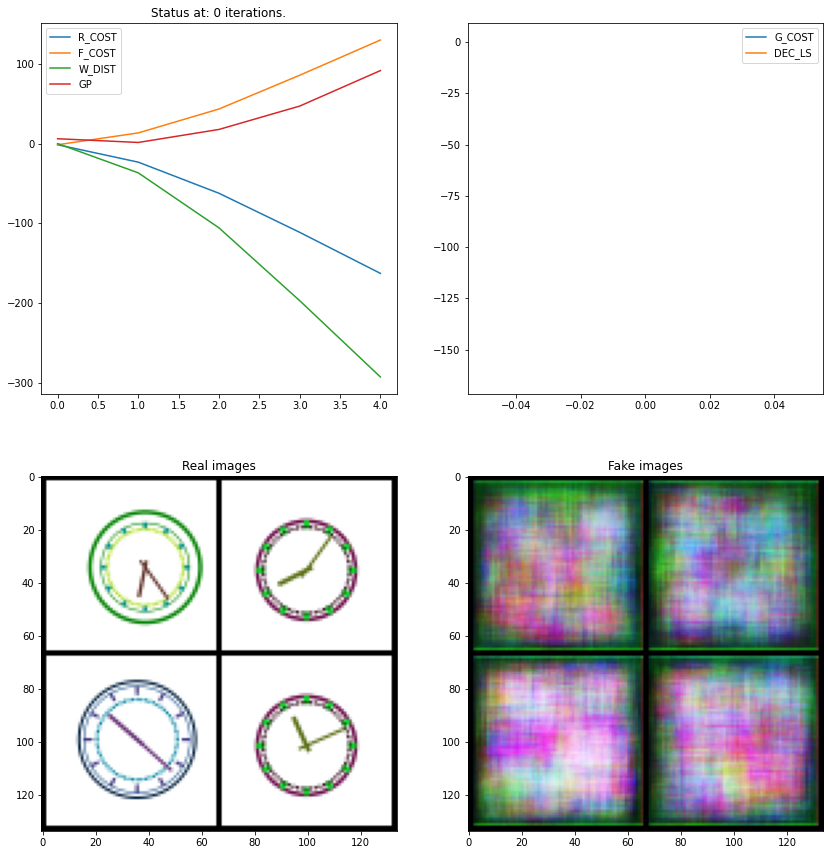

 D_real -162.774, D_fake 129.895, gradient_penalty 91.553, G_cost 163.315, DEC_loss1.045,  0:   0%|          | 0/3125 [00:08<?, ?it/s]

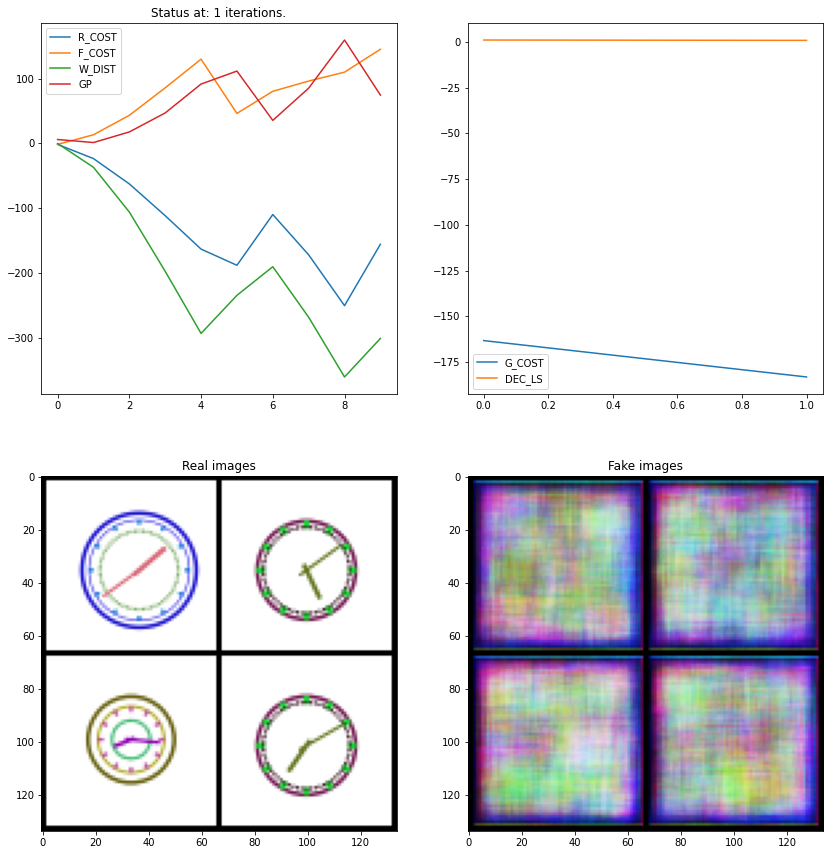

 D_real -49.324, D_fake 124.551, gradient_penalty 52.023, G_cost 131.321, DEC_loss0.282,  8:   0%|          | 0/3125 [00:27<?, ?it/s] 

KeyboardInterrupt: 

In [9]:
data_len = len(dataloader)
D_real = 1
D_fake = -1
gradient_penalty = opt.lambda_value
G_cost = 1
DEC_LS = []
loss = 1
for epoch in range(opt.nEpochs):
    plog("Epoch: ", epoch, " of ", opt.nEpochs, " iters: ", iters)
    data_iter = iter(dataloader)
    
    #Now, let's train it
    #This is being doen due to multi-threading
    org_r_state = np.random.get_state()
    np.random.seed(2)
    s_style_iter = iter(same_style_dloader)
    np.random.set_state(org_r_state)
    
    i = 0
    pbar = tqdm(total=len(data_iter)//opt.critic_iters)
    #pbar = tqdm(range(len(data_iter)//opt.critic_iters))
    while i < data_len - opt.critic_iters:
        pbar.set_description( (" D_real {:.3f}, D_fake {:.3f}, "\
    +  "gradient_penalty {:.3f}, G_cost {:.3f}, DEC_loss{:.3f},  {}").format(
            float(D_real), float(D_fake), 
            float(gradient_penalty), float(G_cost), float(loss), iters))
        #pbar.update(1)
        iters += 1
        ############################
        # (1) Update D network
        ###########################
        for p in D.parameters():  # reset requires_grad
            p.requires_grad = True  # they are set to False below in netG update
        #
        for iter_d in range(opt.critic_iters):
            data = next(data_iter)[0]
            i += 1
            if cuda:
                data = data.cuda(gpu)
            #
            D.zero_grad()
            #
            # train with real
            data = data.float()
            D_real = D(data.float())
            D_real = D_real.mean().reshape(1)
            if iters == 0 and iter_d == 0: plog("D_real.shape: ",D_real.shape)
            D_real.backward(one)
            #
            # train with fake
            noise = torch.randn(opt.batchSize, g_nz)
            if cuda:
                noise = noise.cuda(gpu)
            #noisev = autograd.Variable(noise, volatile=True)  # totally freeze netG
            #fake = autograd.Variable(
            with torch.no_grad():
                fakes = G(noise).data
            D_fake = D(fakes)
            D_fake = D_fake.mean().reshape(1)
            if iters == 0 and iter_d == 0: plog("D_fake.shape: ",D_fake.shape)
            D_fake.backward(mone)
            #
            # train with gradient penalty
            gradient_penalty = calc_gradient_penalty(D, data.data, 
                                                     fakes.data)
            if iters == 0 and iter_d == 0: plog("gradient_penalty.shape: ",gradient_penalty.shape)
            gradient_penalty.backward()
            GP.append(float(gradient_penalty))
            R_COST.append(float(D_real))
            F_COST.append(float(D_fake))
            Wasserstein_D = D_real - D_fake
            W_DIST.append(float(Wasserstein_D))
            D_cost = D_fake - D_real + gradient_penalty
            #
            optD.step()
            D_COST.append(float(D_cost))
        #
        ############################
        # (2) Update G network
        ###########################
        for p in D.parameters():
            p.requires_grad = False  # to avoid computation
        G.zero_grad()
        #
        noise = torch.randn(opt.batchSize, g_nz)
        if cuda:
            noise = noise.cuda(gpu)
        fakes =G(noise)
        G_cost = D(fakes)
        G_cost = G_cost.mean().reshape(1)
        G_cost.backward(one)
        optG.step()
        G_COST.append(-float(G_cost))
        #
        ############################################
        # Now one iteration of Decoder training
        ###########################################
        #This is being doen due to multi-threading
        org_r_state = np.random.get_state()
        np.random.seed(2)
        #
        dec_data, H, M = next(s_style_iter)
        np.random.set_state(org_r_state)
        #
        HM = torch.cat([H, M], axis=1).cuda(gpu)
        #
        optPreG.zero_grad()
        optG.zero_grad()
        #
        hm_to_g = preG(HM)
        #Now we add a little noise
        hm_to_g += torch.randn(hm_to_g.shape).cuda(gpu)/1000
        inp_g = torch.cat([hm_to_g, s_style_noise], axis = 1)
        dec_op = G(inp_g)
        loss = mse(dec_data.cuda(gpu), dec_op)
        DEC_LS.append(float(loss))
        loss.backward()
        optG.step()
        optPreG.step()
        if iters%5000 == 0 or iters in disp_itrs:
            disp_data = []
            for d_i in range(2):
                disp_data.append(data[d_i].data)
                disp_data.append(dec_data[d_i].cuda(gpu).data)
                #Here style for first two clocks shall match
                #Style for the next two!! 
                #But time should be same as in disp_data 2nd and 4th
                with torch.no_grad():
                    #We only modify the time...
                    fixed_noise[d_i][:opt.hm_gen_size] = \
                    preG(HM[d_i]).data
                    #fixed_noise[d_i][:opt.hm_gen_size] = \
                    #fixed_noise[d_i+2][:opt.hm_gen_size]
            oToPickle = {}
            oToPickle["fixed_noise"] = fixed_noise
            #preG, optPreG
            oToPickle["preG"] = preG.state_dict()
            oToPickle["optPreG"] = optPreG.state_dict()
            generate_image([D, G, optD, optG],
                           iters, torch.stack(disp_data), 
                           loss_dict1 = {"R_COST":R_COST,
                                        "F_COST":F_COST,
                                        "W_DIST":W_DIST,
                                        #"D_COST":D_COST,
                                        "GP":GP}, 
                           loss_dict2 = {"G_COST":G_COST,
                                        "DEC_LS":DEC_LS,
                                        },
                           oToPickle = oToPickle)#, fakes.data)
        #if ntbk and iters > 500:
        #    break
    pbar.close()
#with batch